In [8]:
import numpy as np
%matplotlib inline
import seaborn as sns
import scipy.stats

In [9]:
class ABC_class(object):
    ''' Simple ABC class for e.g. Expoentially distributed model, gamma prior for parameters, 
    a,b hyper parameters for prior'''
    def __init__(self,ndata,true_l,a,b):
        self.ndata = ndata
        self.true_l = true_l
        self.hyper_a = a
        self.hyper_b = b
        self.data=self.model(self.true_l,self.ndata) 
    
    #simulate the data, one parameter
    def model(self,l_,num):
        b = 1/l_
        return np.random.exponential(b,num)

    #prior for parameter
    def prior(self):
        k=self.hyper_a
        theta = 1./self.hyper_b
        return np.random.gamma(k,theta)

    # expoential and gamma distrbutions are conjugate distrbutions, so we know the "true" posterior for parameter
    def true_post(self,size):
        k=self.hyper_a+self.ndata
        b = self.hyper_b + self.ndata*np.mean(self.data)
        theta = 1./b
        return np.random.gamma(k,theta,size=size)

    #the all important metric to compare data with simulation/mock
    def dist(self,x):
        return np.abs(np.mean(x) - np.mean(self.data))
    
    #returns gamma prob of value
    def return_priorprob(self,value):
        x = 1./self.hyper_b
        return scipy.stats.gamma.pdf(value, self.hyper_a,scale=x)
    
def return_normalprob(value,mu,std):
    return scipy.stats.norm.pdf(value, loc=mu,scale=std) 


10.1600744478 10.0958354688


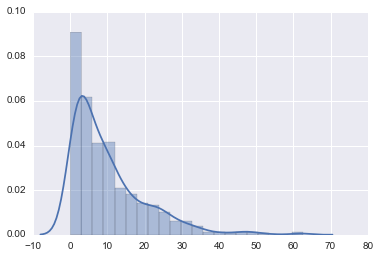

In [10]:
# First create some mock data
#data
n=500
lbda = 0.1 # "True" value of parameter

#hyperparameters for beta prior
a=0.1
b=0.1

abc = ABC_class(n,lbda,a,b)
#plot data
sns.distplot(abc.data)
print np.mean(abc.data), np.std(abc.data)

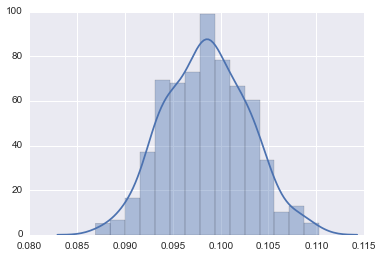

In [11]:
#true posterior    
sns.distplot(abc.true_post(500))

In [14]:
#start ABC PMC iterations with NPart "particles" taking NumT iterations. 
#Here the tolerance level is decreasing as we move around parameter space

NPart = 100
Nsamples =500
n=500
tol = [3.,1.,1E-1,1.E-3,1.E-4,1.E-5]
NumT =3


lbda = 0.1
a=0.1
b=0.1
abc = ABC_class(n,lbda,a,b)

#Empty arrays to hold the posterior values, weights and variances for each particle
theta=np.zeros([NumT,NPart])
wgt=np.zeros([NumT,NPart])
var = np.zeros(NumT)

y=abc.data

#First iteration - just sample from the prior for all particles, then assign first weights w_i = 1/N for each particle.
t=0
for i in np.arange(NPart):
    x=1.E8
    while abc.dist(x) > tol[t]:
        t1 = abc.prior()
        x = abc.model(t1,Nsamples)
    theta[t][i]=t1
    wgt[t][i]=1./NPart
var[t] = 2.*np.std(theta[t])**2

#t>0 iterations, choose random particle from iteration t-1 based on t-1 weights, propose new particle,
# generate mock data, calculate distance, keep particle if distance < tolerance. Calculate new weights for all particles
# based on kernal using all other particles, variance  = 2*std of all particles 

for t in np.arange(1,NumT): 
    for i in np.arange(NPart):
        x=1.E8
        while abc.dist(x) > tol[t]:
            t1=np.random.choice(theta[t-1],size=1,p=wgt[t-1])
            t2 = np.abs(np.random.normal(t1,np.sqrt(var[t-1])))
            x = abc.model(t2,Nsamples)
        theta[t][i] = t2
        kernal = [ return_normalprob(t_back , t2,np.sqrt(var[t-1])) for t_back in theta[t-1]] 
        wgt[t][i] = abc.return_priorprob(t2)/(np.sum(wgt[t-1]*kernal))
    var[t] = 2.*np.std(theta[t])**2
    wgt[t] = wgt[t]/np.sum(wgt[t])




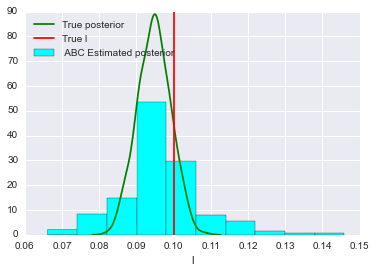

In [15]:
#Plot
ax=sns.distplot(abc.true_post(500), color='green', hist=False,label="True posterior")
ax.plot([abc.true_l,abc.true_l],[0,90],color='red',label="True l")
ax.hist(theta.flatten(),color="cyan",normed=1, histtype='bar',label=" ABC Estimated posterior")
ax.legend(frameon=False,loc=2)
ax.set_xlabel('l')